In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image
import os, sys, random
import json
import xml.etree.ElementTree as ET
from glob import glob
from shutil import copyfile
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import argparse as ap
import random
import math
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torchvision.models as models
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torch.utils.data import DataLoader
from torch.optim import Adam
sys.path.append('/content/drive/MyDrive/a-PyTorch-Tutorial-to-Object-Detection-master/')
from torchvision.transforms import functional as FT
from torchvision.transforms import ToTensor
from torch import nn
from m_utils import *
import torch.nn.functional as F
from math import sqrt
from itertools import product as product
import torchvision
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch
from model import SSD300, MultiBoxLoss
from datasets import PascalVOCDataset

In [ ]:
directory = '/content/drive/MyDrive/BCCD/Annotations/'
for filename in os.listdir(directory):
    if filename.endswith('.xml'):
        annotation_path = os.path.join(directory, filename)
        result = parse_annotation(annotation_path)



In [ ]:
result

{'boxes': [[517, 167, 610, 267],
  [425, 86, 550, 197],
  [501, 297, 610, 410],
  [249, 244, 370, 356],
  [57, 103, 169, 214],
  [377, 257, 503, 367],
  [227, 125, 319, 216],
  [168, 78, 260, 169],
  [1, 0, 92, 82],
  [15, 228, 120, 312],
  [6, 262, 114, 366],
  [348, 126, 455, 285],
  [437, 0, 562, 76],
  [226, 70, 309, 149],
  [412, 395, 455, 432],
  [333, 209, 376, 247],
  [179, 168, 212, 216],
  [77, 14, 121, 50],
  [77, 292, 305, 479]],
 'labels': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3],
 'difficulties': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [ ]:
create_data_lists('/content/drive/MyDrive/BCCD/', '/content/drive/MyDrive/BCCD/jsons')


There are 328 training images containing a total of 984 objects. Files have been saved to /content/drive/MyDrive/BCCD/jsons.

There are 36 test images containing a total of 108 objects. Files have been saved to /content/drive/MyDrive/BCCD/jsons.


In [ ]:
class PascalVOCDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, split, keep_difficult=False):
        """
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        :param keep_difficult: keep or discard objects that are considered difficult to detect?
        """
        self.split = split.upper()

        assert self.split in {'TRAIN', 'TEST'}

        self.data_folder = data_folder
        self.keep_difficult = keep_difficult

        # Read data files
        with open(os.path.join(data_folder, self.split + '_images.json'), 'r') as j:
            self.images = json.load(j)
        with open(os.path.join(data_folder, self.split + '_objects.json'), 'r') as j:
            self.objects = json.load(j)

        assert len(self.images) == len(self.objects)

    def __getitem__(self, i):
        # Read image
        image = Image.open(self.images[i], mode='r')
        image = image.convert('RGB')

        # Read objects in this image (bounding boxes, labels, difficulties)
        objects = self.objects[i]
        boxes = torch.FloatTensor(objects['boxes'])  # (n_objects, 4)
        labels = torch.LongTensor(objects['labels'])  # (n_objects)
        difficulties = torch.ByteTensor(objects['difficulties'])  # (n_objects)

        # Discard difficult objects, if desired
        if not self.keep_difficult:
            boxes = boxes[1 - difficulties]
            labels = labels[1 - difficulties]
            difficulties = difficulties[1 - difficulties]

        # Apply transformations
        image, boxes, labels, difficulties = transform(image, boxes, labels, difficulties, split=self.split)

        return image, boxes, labels, difficulties

    def __len__(self):
        return len(self.images)

    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).

        This describes how to combine these tensors of different sizes. We use lists.

        Note: this need not be defined in this Class, can be standalone.

        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """

        images = list()
        boxes = list()
        labels = list()
        difficulties = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
            difficulties.append(b[3])

        images = torch.stack(images, dim=0)

        return images, boxes, labels, difficulties  # tensor (N, 3, 300, 300), 3 lists of N tensors each


In [ ]:
train_dataset = PascalVOCDataset(data_folder='/content/drive/MyDrive/BCCD/jsons', split='TRAIN', keep_difficult=False)
test_dataset = PascalVOCDataset(data_folder='/content/drive/MyDrive/BCCD/jsons', split='TEST', keep_difficult=True)

In [ ]:
len(train_dataset)

328

In [ ]:

# Data parameters
data_folder = '/content/drive/MyDrive/BCCD/jsons'  # folder with data files
keep_difficult = True  # use objects considered difficult to detect?

# Model parameters
# Not too many here since the SSD300 has a very specific structure
n_classes = len(label_map)  # number of different types of objects
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Learning parameters
checkpoint = None  # path to model checkpoint, None if none
batch_size = 8  # batch size
iterations = 120  # number of iterations to train
workers = 2  # number of workers for loading data in the DataLoader
print_freq = 200  # print training status every __ batches
lr = 1e-3  # learning rate
decay_lr_at = [80000, 100000]  # decay learning rate after these many iterations
decay_lr_to = 0.1  # decay learning rate to this fraction of the existing learning rate
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
grad_clip = None  # clip if gradients are exploding, which may happen at larger batch sizes (sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation

cudnn.benchmark = True


def main():
    """
    Training.
    """
    global start_epoch, label_map, epoch, checkpoint, decay_lr_at

    # Initialize model or load checkpoint
    if checkpoint is None:
        start_epoch = 0
        model = SSD300(n_classes=n_classes)
        # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
        biases = list()
        not_biases = list()
        for param_name, param in model.named_parameters():
            if param.requires_grad:
                if param_name.endswith('.bias'):
                    biases.append(param)
                else:
                    not_biases.append(param)
        optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                    lr=lr, momentum=momentum, weight_decay=weight_decay)

    else:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch'] + 1
        print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
        model = checkpoint['model']
        optimizer = checkpoint['optimizer']

    # Move to default device
    model = model.to(device)
    criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

    # Custom dataloaders
    train_dataset = PascalVOCDataset(data_folder,
                                     split='train',
                                     keep_difficult=keep_difficult)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                               collate_fn=train_dataset.collate_fn, num_workers=workers,
                                               pin_memory=True)  # note that we're passing the collate function here

    # Calculate total number of epochs to train and the epochs to decay learning rate at (i.e. convert iterations to epochs)
    # To convert iterations to epochs, divide iterations by the number of iterations per epoch
    # The paper trains for 120,000 iterations with a batch size of 32, decays after 80,000 and 100,000 iterations
    epochs = iterations // (len(train_dataset) // 32)
    decay_lr_at = [it // (len(train_dataset) // 32) for it in decay_lr_at]

    # Epochs
    for epoch in range(start_epoch, epochs):

        # Decay learning rate at particular epochs
        if epoch in decay_lr_at:
            adjust_learning_rate(optimizer, decay_lr_to)

        # One epoch's training
        train(train_loader=train_loader,
              model=model,
              criterion=criterion,
              optimizer=optimizer,
              epoch=epoch)

        # Save checkpoint
        save_checkpoint(epoch, model, optimizer)


def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.

    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables dropout

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss

    start = time.time()

    # Batches
    for i, (images, boxes, labels, _) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        images = images.to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        # Forward prop.
        predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

        # Loss
        loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        # Update model
        optimizer.step()

        losses.update(loss.item(), images.size(0))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(epoch, i, len(train_loader),
                                                                  batch_time=batch_time,
                                                                  data_time=data_time, loss=losses))
    del predicted_locs, predicted_scores, images, boxes, labels  # free some memory since their histories may be stored

if __name__ == '__main__':
    main()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 180MB/s]



Loaded base model.



/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: [0][0/41]	Batch Time 21.180 (21.180)	Data Time 7.931 (7.931)	Loss 16.0925 (16.0925)	
Epoch: [1][0/41]	Batch Time 0.844 (0.844)	Data Time 0.541 (0.541)	Loss 5.7825 (5.7825)	
Epoch: [2][0/41]	Batch Time 1.254 (1.254)	Data Time 0.948 (0.948)	Loss 4.3691 (4.3691)	
Epoch: [3][0/41]	Batch Time 1.024 (1.024)	Data Time 0.715 (0.715)	Loss 3.6911 (3.6911)	
Epoch: [4][0/41]	Batch Time 1.296 (1.296)	Data Time 0.985 (0.985)	Loss 3.5172 (3.5172)	
Epoch: [5][0/41]	Batch Time 0.819 (0.819)	Data Time 0.507 (0.507)	Loss 3.3214 (3.3214)	
Epoch: [6][0/41]	Batch Time 1.020 (1.020)	Data Time 0.716 (0.716)	Loss 3.1820 (3.1820)	
Epoch: [7][0/41]	Batch Time 0.943 (0.943)	Data Time 0.640 (0.640)	Loss 3.4102 (3.4102)	
Epoch: [8][0/41]	Batch Time 0.774 (0.774)	Data Time 0.467 (0.467)	Loss 3.3988 (3.3988)	
Epoch: [9][0/41]	Batch Time 1.388 (1.388)	Data Time 1.075 (1.075)	Loss inf (inf)	
Epoch: [10][0/41]	Batch Time 1.402 (1.402)	Data Time 1.100 (1.100)	Loss 2.9535 (2.9535)	
Epoch: [11][0/41]	Batch Time 1.14

In [ ]:
from tqdm import tqdm
from pprint import PrettyPrinter
# Good formatting when printing the APs for each class and mAP
pp = PrettyPrinter()

# Parameters
data_folder = '/content/drive/MyDrive/BCCD/jsons'
keep_difficult = True  # difficult ground truth objects must always be considered in mAP calculation, because these objects DO exist!
batch_size = 64
workers = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = './checkpoint_ssd300.pth.tar'

# Load model checkpoint that is to be evaluated
checkpoint = torch.load(checkpoint)
model = checkpoint['model']
model = model.to(device)

# Switch to eval mode
model.eval()

# Load test data
test_dataset = PascalVOCDataset(data_folder,
                                split='test',
                                keep_difficult=keep_difficult)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                          collate_fn=test_dataset.collate_fn, num_workers=workers, pin_memory=True)


def evaluate(test_loader, model):
    """
    Evaluate.

    :param test_loader: DataLoader for test data
    :param model: model
    """

    # Make sure it's in eval mode
    model.eval()

    # Lists to store detected and true boxes, labels, scores
    det_boxes = list()
    det_labels = list()
    det_scores = list()
    true_boxes = list()
    true_labels = list()
    true_difficulties = list()  # it is necessary to know which objects are 'difficult', see 'calculate_mAP' in utils.py

    with torch.no_grad():
        # Batches
        for i, (images, boxes, labels, difficulties) in enumerate(tqdm(test_loader, desc='Evaluating')):
            images = images.to(device)  # (N, 3, 300, 300)

            # Forward prop.
            predicted_locs, predicted_scores = model(images)

            # Detect objects in SSD output
            det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores,
                                                                                       min_score=0.01, max_overlap=0.45,
                                                                                       top_k=200)
            # Evaluation MUST be at min_score=0.01, max_overlap=0.45, top_k=200 for fair comparision with the paper's results and other repos

            # Store this batch's results for mAP calculation
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            difficulties = [d.to(device) for d in difficulties]

            det_boxes.extend(det_boxes_batch)
            det_labels.extend(det_labels_batch)
            det_scores.extend(det_scores_batch)
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            true_difficulties.extend(difficulties)

        # Calculate mAP
        APs, mAP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties)

    # Print AP for each class
    pp.pprint(APs)

    print('\nMean Average Precision (mAP): %.3f' % mAP)


if __name__ == '__main__':
    evaluate(test_loader, model)


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]/content/drive/MyDrive/a-PyTorch-Tutorial-to-Object-Detection-master/model.py:507: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/content/drive/MyDrive/a-PyTorch-Tutorial-to-Object-Detection-master/model.py:509: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  image_scores.append(class_scores[1 - suppress])
Evaluating: 100%|██████████| 1/1 [00:42<00:00, 42.94s/it]


{'Platelets': 0.7599204182624817,
 'RBC': 0.7917176485061646,
 'WBC': 0.8999780416488647}

Mean Average Precision (mAP): 0.817


In [ ]:
from detect import *
from PIL import ImageFont

font = ImageFont.load_default()

In [ ]:
from torchvision import transforms
from m_utils import *
import torch
from PIL import Image, ImageDraw, ImageFont

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model checkpoint
checkpoint = 'checkpoint_ssd300.pth.tar'
checkpoint = torch.load(checkpoint)
start_epoch = checkpoint['epoch'] + 1
print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
model = checkpoint['model']
model = model.to(device)
model.eval()

# Transforms
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


def detect(original_image, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.

    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """

    # Transform
    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)

    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return original_image

    # Annotate
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.load_default()

    # Suppress specific classes, if needed
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
            det_labels[i]])  # a second rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 2. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a third rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 3. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a fourth rectangle at an offset of 1 pixel to increase line thickness

        # Text
        text_size = font.getsize(det_labels[i].upper())
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=det_labels[i].upper(), fill='white',
                  font=font)
    del draw

    return annotated_image






Loaded checkpoint from epoch 12.



In [ ]:
    img_path = '/content/drive/MyDrive/BCCD/JPEGImages/BloodImage_00011.jpg'
    original_image = Image.open(img_path, mode='r')
    original_image = original_image.convert('RGB')
    res = detect(original_image, min_score=0.5, max_overlap=0.5, top_k=200)

<ipython-input-11-75c8c40aeac1>:87: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_size = font.getsize(det_labels[i].upper())


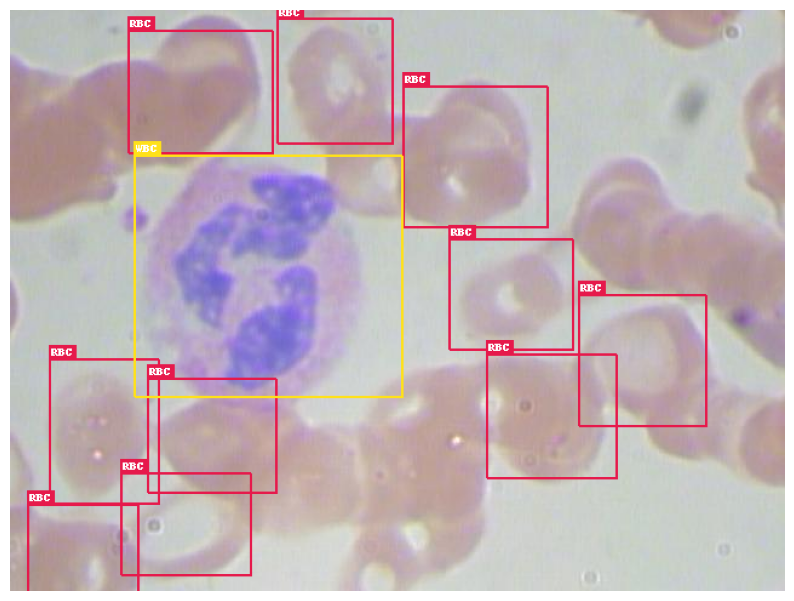

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(res)
plt.axis('off')
plt.show()
